Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


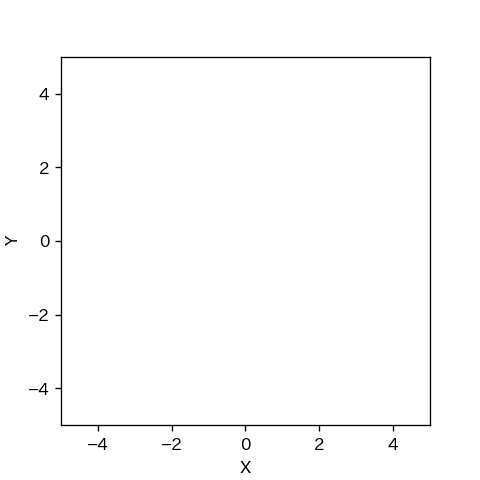

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_phantom_trap_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m,phantom_prob=0.1),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
#, phantom_prob=0.1
    world.draw()
    return (r.pose,pf.ml.pose)

In [4]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_phantom_trap_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[2.372158899092859]
0 真値: [-4.59822977  0.38297213  4.15378696] 推定値: [-6.62893461  5.36848783  4.03591165] 誤差: 5.383226633595346
1 真値: [-6.34473591  4.32241512  5.15457296] 推定値: [-3.64193803 -2.47314817  7.55702455] 誤差: 7.313330072995439
[1.7570959741064698]
2 真値: [-2.58269247  4.78573739  2.73091697] 推定値: [-1.62497465  3.62071758  3.07605958] 誤差: 1.5081427599335975
[3.6909211925404293]
3 真値: [ 1.42702884 -4.27829896  1.84855394] 推定値: [ 1.19064971 -4.22999393  1.68044865] 誤差: 0.24126431702464998
1
[2.6003353157200055]
[2.369023751049111, 5.344008950672005]
4 真値: [ 4.16440425 -2.79933461  2.55907139] 推定値: [ 3.89462457 -2.76945775  2.53269194] 誤差: 0.271428999032946
2
5 真値: [2.57936587 3.60406375 2.37599906] 推定値: [3.21613342 1.40911024 5.32926408] 誤差: 2.2854526537276243
[2.5101621714596436]
[3.975110902752613]
[5.8677112045743245, 3.7755943553009588]
6 真値: [0.30841576 1.90964558 0.17936312] 推定値: [0.78485996 1.39897026 0.46515159] 誤差: 0.6984184727052025
3
[0.6397695032331685]
7 真値: [-0.699

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[5.316970378385008]
20 真値: [-2.3067103   2.23638734  2.701891  ] 推定値: [-3.28621229  3.34849757  3.64485657] 誤差: 1.481962654311859
[5.454968614015586]
21 真値: [-0.20857851  3.06685128  0.88894355] 推定値: [ 4.28103492  5.95516834 -1.05336884] 誤差: 5.338445856364365
[4.642843644595083]
22 真値: [ 5.69237856 -0.28221919  2.91871889] 推定値: [ 5.61583176 -2.12719491  8.67071722] 誤差: 1.8465629727175552
23 真値: [5.24433037 3.04279752 1.07722136] 推定値: [0.97562116 5.26017219 3.57024555] 誤差: 4.810262862409687
[3.8144125420872057]
24 真値: [-2.48864623  0.14798227  4.57815957] 推定値: [-5.11445188 -0.2182494   4.50641867] 誤差: 2.6512225327832186
[4.8094037849039495]
[2.977102802092144]
25 真値: [-2.55485725  0.29365739  1.52472308] 推定値: [-2.49221353  0.72087808  1.82399094] 誤差: 0.43178901325538327
6
26 真値: [-2.31367705 -1.31225737  0.73246581] 推定値: [-0.92170938  1.26764945  6.34548684] 誤差: 2.931466050901739
27 真値: [-0.78642267 -3.31117804  1.47604869] 推定値: [ 5.56719932 -1.54735523  6.514246  ] 誤差: 6.59390501266111